In [9]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Draw
from IPython.display import display, Image
import io
from collections import Counter
#from spellchecker import SpellChecker
from ast import literal_eval
from collections import defaultdict
import sys

In [10]:
# Some code to remove NaN smiles
def remove_nan_smiles(df):
    print("--- REMOVING NAN SMILES ---")
    print(f"\tOriginal size before removing NaN SMILES: {len(df)}")
    df = df.dropna(subset=['IsomericSMILES'])
    print(f"\tSize after removing NaN SMILES: {len(df)}")
    return df

# Some code to purge undesirable elements
def contains_undesirable_elements(smiles, undesirable_elements_list):
    undesirable_smarts = [Chem.MolFromSmarts(f'[{element}]') for element in undesirable_elements_list]
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"\tWarning: Could not parse SMILES: {smiles}")
        return True
    for i, smarts in enumerate(undesirable_smarts):
        if mol.HasSubstructMatch(smarts):
            print(f"\tMatch found: SMILES {smiles} contains {undesirable_elements_list[i]}")
            return True
    return False

def remove_undesirable_elements(df):
    print("--- REMOVING UNDESIRABLE ELEMENTS ---")
    print(f"\tOriginal size before removing undesirable elements: {len(df)}")
    undesirable_elements_list = ["Na", "K", "Ca", "Mg", "Cr", "B", "Si", "Ti", "Fe", "Al", "Co", "Zn", "Cu", "V", "Bi", "He"]
    print(f"\tPurging undesirable elements in {undesirable_elements_list}")
    df['contains_undesirable_elements'] = df.apply(lambda row: contains_undesirable_elements(row['IsomericSMILES'], undesirable_elements_list), axis=1)
    print(f"\tTotal undesirable element SMILES removed: {len(df[df['contains_undesirable_elements'] == True])}")
    df_filtered = df[~df['contains_undesirable_elements']].copy()
    df_filtered.drop(columns=['contains_undesirable_elements'], inplace=True)
    return df_filtered

# Some code to lowercase labels and merge them together
def lowercase_and_merge_labels(df, column_list):
    print("--- LOWERCASING AND MERGING LABELS ---")
    print(f"\tLength of original descriptor list before lowercase and merge: {len(column_list)}")
    # Convert all column names to lowercase
    df.rename(columns={col: col.lower() for col in column_list if col in df.columns}, inplace=True)
    
    # Identify lowercase columns that are now duplicates
    lowercase_columns = [col.lower() for col in column_list if col.lower() in df.columns]
    duplicate_columns = set([col for col in lowercase_columns if lowercase_columns.count(col) > 1])
    
    # Merge duplicate columns
    for col in duplicate_columns:
        duplicate_cols = [c for c in df.columns if c == col]
        df[col] = df[duplicate_cols].any(axis=1)
        # Drop all but one of the duplicate columns
        df.drop(columns=duplicate_cols[1:], inplace=True)
    
    # Create new list of columns without duplicates
    new_column_list = [col for col in lowercase_columns if col in df.columns]
    

    # Print non-unique column names
    if duplicate_columns:
        print("\tNon-unique column names after lowercase conversion:")
        for col in duplicate_columns:
            print(col)
    

    print(f"\tLength of descriptor list after lowercase and merge: {len(column_list)}")
    
    return df, new_column_list


# Some code to fix spelling mistakes in labels?
def fix_spelling_mistakes(df, column_list):
    spell = SpellChecker()
    for col in column_list:
        misspelled = spell.unknown(df[col].unique())
        for word in misspelled:
            # Get the one `most likely` answer
            print(f"\tMisspelled word: {word}, possible corrections: {spell.candidates(word)}")
    return df

# Some code to purge low label counts (<20)
def remove_low_count_columns(df, column_list, threshold=40):
    print("--- REMOVING LOW COUNT COLUMNS ---")
    print(f"\tLength of original descriptor list before low count removal: {len(column_list)}")
    columns_to_remove = []
    for column in column_list:
        column_sum = df[column].astype(bool).sum()
        if column_sum < threshold:
            columns_to_remove.append(column)
            print(f"\tRemoving column '{column}' with total count {column_sum}")
    
    df_filtered = df.drop(columns=columns_to_remove)
    if columns_to_remove == []:
        print(f"\tNo columns are below count threshold {threshold}")
    column_list = [col for col in column_list if col not in columns_to_remove]
    print(f"\tLength of original descriptor list after low count removal: {len(column_list)}")
    return df_filtered, column_list
# Some code to purge large MWs or really small MWs

def visualize_molecule(smiles):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        # Generate a 2D depiction of the molecule
        img = Draw.MolToImage(mol)
        
        # Convert the image to bytes
        bio = io.BytesIO()
        img.save(bio, format='PNG')
        
        # Display the image
        display(Image(bio.getvalue()))
    else:
        print(f"\tInvalid SMILES: {smiles}")

def remove_molecular_weights(df, column_list, lower=20, higher=600):
    print(f"--- REMOVING MOLECULAR WEIGHTS BETWEEN {lower} AND {higher} ---")
    print(f"\tOriginal size before molecular weight thresholding: {len(df)}")
    df['rdkit'] = df.apply(lambda row: Chem.MolFromSmiles(row['IsomericSMILES']), axis=1)
    df['mw'] = df.apply(lambda row: ExactMolWt(row['rdkit']), axis=1)

    print(f"\tMolecules below MW threshold {lower}: {len(df[df['mw'] < lower])}")
    for _, row in df[df['mw'] < lower].iterrows():
        positive_columns = [col for col in column_list if row[col] == 1]
        print(f"\t\t{row['IsomericSMILES']}, {', '.join(positive_columns)}")
        #visualize_molecule(row['IsomericSMILES'])

    print(f"\tMolecules above MW threshold {higher}: {len(df[df['mw'] > higher])}")
    for _, row in df[df['mw'] > higher].iterrows():
        positive_columns = [col for col in column_list if row[col] == 1]
        print(f"\t\t{row['IsomericSMILES']}, {', '.join(positive_columns)}")
        #visualize_molecule(row['IsomericSMILES'])
        
    df_filtered = df[(df['mw'] >= lower) & (df['mw'] <= higher)].copy()
    df_filtered.drop(columns=['rdkit', 'mw'], inplace=True)
    print(f"\tSize after molecular weight thresholding: {len(df_filtered)}")
    return df_filtered

# Some code to purge salts or two-molecules-in-one-SMILES

def contains_salts_and_charges(smiles):
    # Try to create an RDKit molecule from the SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        print(f"\tInvalid SMILES: {smiles}")
        return True

    # Check for charges
    if Chem.GetFormalCharge(mol) != 0:
        print(f"\t{smiles} has charges")
        return True
    return False

def contains_multimolecule(smiles):
    # Try to create an RDKit molecule from the SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        print(f"\tInvalid SMILES: {smiles}")
        return True
    
    # Check for multiple molecules
    if "." in smiles:
        print(f"\t{smiles} has multiple molecules")
        return True

    return False

def remove_salts_and_charges_and_multimolecule(df):
    print("--- REMOVING SALTS, CHARGED MOLECULES AND MULTIMOLECULES ---")
    print(f"\tOriginal size before removing salts, charges and multimolecules: {len(df)}")
    df['contains_salts_and_charges'] = df['IsomericSMILES'].apply(contains_salts_and_charges)
    print(f"\tTotal salts and charged SMILES removed: {len(df[df['contains_salts_and_charges'] == True])}")
    df_filtered = df[~df['contains_salts_and_charges']].copy()
    df_filtered['contains_multimolecule'] = df['IsomericSMILES'].apply(contains_multimolecule)
    print(f"\tTotal multimolecules removed: {len(df_filtered[df_filtered['contains_multimolecule'] == True])}") 
    df_filtered = df_filtered[~df_filtered['contains_multimolecule']].copy()
    df_filtered.drop(columns=['contains_salts_and_charges', 'contains_multimolecule'], inplace=True)
    print(f"\tFinal size after removing salts, charges and multimolecules: {len(df_filtered)}")
    return df_filtered


In [11]:
file_df = pd.read_csv("file_cleaning_features.csv")
file_df.loc[file_df['dataset'] == "keller_2016", 'unclean'] = "keller_2016/keller_2016_unclean_processed.csv"
keller_df = pd.read_csv("keller_2016/keller_2016_unclean_processed.csv")
file_df.loc[file_df['dataset'] == "keller_2016", 'label_columns'] = str(keller_df.columns[:-4].to_list())

file_df.loc[file_df['dataset'] == "abraham_2012", 'label_columns'] = str(['Log (1/ODT)'])

file_df.loc[file_df['dataset'] == "mayhew_2022", 'label_columns'] = str(['Odor'])

regression_datasets = file_df[file_df['task'] == 'regression']['dataset'].to_list()

In [12]:
file_df

,dataset,unclean,label_columns,task
0,arctander_1960,arctander_1960/arctander_1960_unclean.csv,"['acid', 'aldehydic', 'almond', 'ambre', 'anim...",multilabel
1,aromadb,aromadb/aromadb_unclean.csv,"['acetic', 'acid', 'alcoholic', 'almond', 'amm...",NaN
2,flavornet,flavornet/flavornet_unclean.csv,"['acid', 'alcohol', 'alkaline', 'alkane', 'alm...",multilabel
3,ifra_2019,ifra_2019/ifra_2019_unclean.csv,"['Acidic', 'Aldehydic', 'Almond', 'Amber', 'An...",multilabel
4,sigma_2014,sigma_2014/sigma_2014_unclean.csv,"['potato', 'marigold', 'anise', 'herba-', 'car...",multilabel
5,keller_2016,keller_2016/keller_2016_unclean_processed.csv,"['Acid_mean', 'Ammonia_mean', 'Bakery_mean', '...",regression
6,abraham_2012,abraham_2012/abraham_2012_unclean.csv,['Log (1/ODT)'],regression
7,mayhew_2022,mayhew_2022/mayhew_2022_unclean.csv,['Odor'],binary
8,leffingwell,leffingwell/leffingwell_unclean.csv,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",multilabel
9,gs-lf,gs-lf/curated_GS_LF_merged_4983.csv,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",multilabel


In [42]:
# Include OPERA vapor pressure dataset? Regression task
# IsomericSMILES in gslf by merging leffingwell? 
# Look more into other mixture datasets


In [13]:

new_descriptor_labels = {}
#for _, dataset in file_df[file_df['dataset'] == 'ifra_2019'].iterrows():
for _, dataset in file_df.iterrows():
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()

    print(f"Dataset cleaning report for {dataset['dataset']}")
    df = pd.read_csv(dataset['unclean'])

    if 'nonStereoSMILES' in df.columns:
        df.rename(columns={'nonStereoSMILES': "IsomericSMILES"}, inplace=True)

    descriptor_list = literal_eval(dataset['label_columns'])

    # Remove undesirable SMILES first
    df_filtered = remove_nan_smiles(df)
    df_filtered = remove_undesirable_elements(df_filtered)
    df_filtered = remove_salts_and_charges_and_multimolecule(df=df_filtered)
    df_filtered = remove_molecular_weights(df=df_filtered, column_list=descriptor_list, lower=20, higher=600)

    # Then filter descriptors
    print("--- COLUMN PROCESSING ---")
    if dataset['dataset'] not in regression_datasets:
        print(f"\t{dataset['dataset']} is a classification dataset. Cleaning columns")
        df_filtered, descriptor_list = remove_low_count_columns(df=df_filtered, column_list=descriptor_list, threshold=20)
        df_filtered, descriptor_list = lowercase_and_merge_labels(df_filtered, descriptor_list)
    else:
        print(f"\t{dataset['dataset']} is a regression dataset. Columns are untouched")

    print(f"--- DATASET CLEANING COMPLETE ---")
    print(f"\tFinal size of dataframe: {len(df_filtered)}")

    df_filtered.to_csv(f"{dataset['dataset']}/{dataset['dataset']}_combined.csv", index=False)

    output = sys.stdout.getvalue()

    with open(f"{dataset['dataset']}/{dataset['dataset']}_cleaning_report.txt", 'w') as file:
        file.write(output)

    # Restore the original stdout
    sys.stdout = old_stdout

    # Find ways to automake the labels and descriptor numbers
    new_descriptor_labels[dataset['dataset']] = {'new_label_columns': str(descriptor_list),
                                                'task_dim': len(descriptor_list),
                                                'n_datapoints': len(df_filtered),
                                                'features': str(['IsomericSMILES']),
                                                'validate': True}

/tmp/ipykernel_5072/3054758604.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contains_undesirable_elements'] = df.apply(lambda row: contains_undesirable_elements(row['IsomericSMILES'], undesirable_elements_list), axis=1)
/tmp/ipykernel_5072/3054758604.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contains_undesirable_elements'] = df.apply(lambda row: contains_undesirable_elements(row['IsomericSMILES'], undesirable_elements_list), axis=1)


In [14]:
new_df = pd.DataFrame(new_descriptor_labels).T
new_df.reset_index(inplace=True)
new_df.rename(columns={'index': 'dataset'}, inplace=True)
file_df = pd.merge(file_df, new_df, on='dataset', how='left')

In [15]:
file_df

,dataset,unclean,label_columns,task,new_label_columns,task_dim,n_datapoints,features,validate
0,arctander_1960,arctander_1960/arctander_1960_unclean.csv,"['acid', 'aldehydic', 'almond', 'ambre', 'anim...",multilabel,"['aldehydic', 'almond', 'ambre', 'animal', 'an...",59,2688,['IsomericSMILES'],True
1,aromadb,aromadb/aromadb_unclean.csv,"['acetic', 'acid', 'alcoholic', 'almond', 'amm...",NaN,"['balsamic', 'camphoraceous', 'citrus', 'flora...",12,866,['IsomericSMILES'],True
2,flavornet,flavornet/flavornet_unclean.csv,"['acid', 'alcohol', 'alkaline', 'alkane', 'alm...",multilabel,"['alkane', 'citrus', 'earth', 'fat', 'flower',...",14,716,['IsomericSMILES'],True
3,ifra_2019,ifra_2019/ifra_2019_unclean.csv,"['Acidic', 'Aldehydic', 'Almond', 'Amber', 'An...",multilabel,"['aldehydic', 'amber', 'anisic', 'apple', 'bal...",33,1118,['IsomericSMILES'],True
4,sigma_2014,sigma_2014/sigma_2014_unclean.csv,"['potato', 'marigold', 'anise', 'herba-', 'car...",multilabel,"['anise', 'rose', 'coffee', 'creamy', 'herbace...",41,855,['IsomericSMILES'],True
5,keller_2016,keller_2016/keller_2016_unclean_processed.csv,"['Acid_mean', 'Ammonia_mean', 'Bakery_mean', '...",regression,"['Acid_mean', 'Ammonia_mean', 'Bakery_mean', '...",132,477,['IsomericSMILES'],True
6,abraham_2012,abraham_2012/abraham_2012_unclean.csv,['Log (1/ODT)'],regression,['Log (1/ODT)'],1,266,['IsomericSMILES'],True
7,mayhew_2022,mayhew_2022/mayhew_2022_unclean.csv,['Odor'],binary,['odor'],1,1872,['IsomericSMILES'],True
8,leffingwell,leffingwell/leffingwell_unclean.csv,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",multilabel,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",113,3521,['IsomericSMILES'],True
9,gs-lf,gs-lf/curated_GS_LF_merged_4983.csv,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",multilabel,"['alcoholic', 'aldehydic', 'alliaceous', 'almo...",138,4815,['IsomericSMILES'],True


In [16]:
file_df.to_csv("file_cleaning_features.csv", index=False)

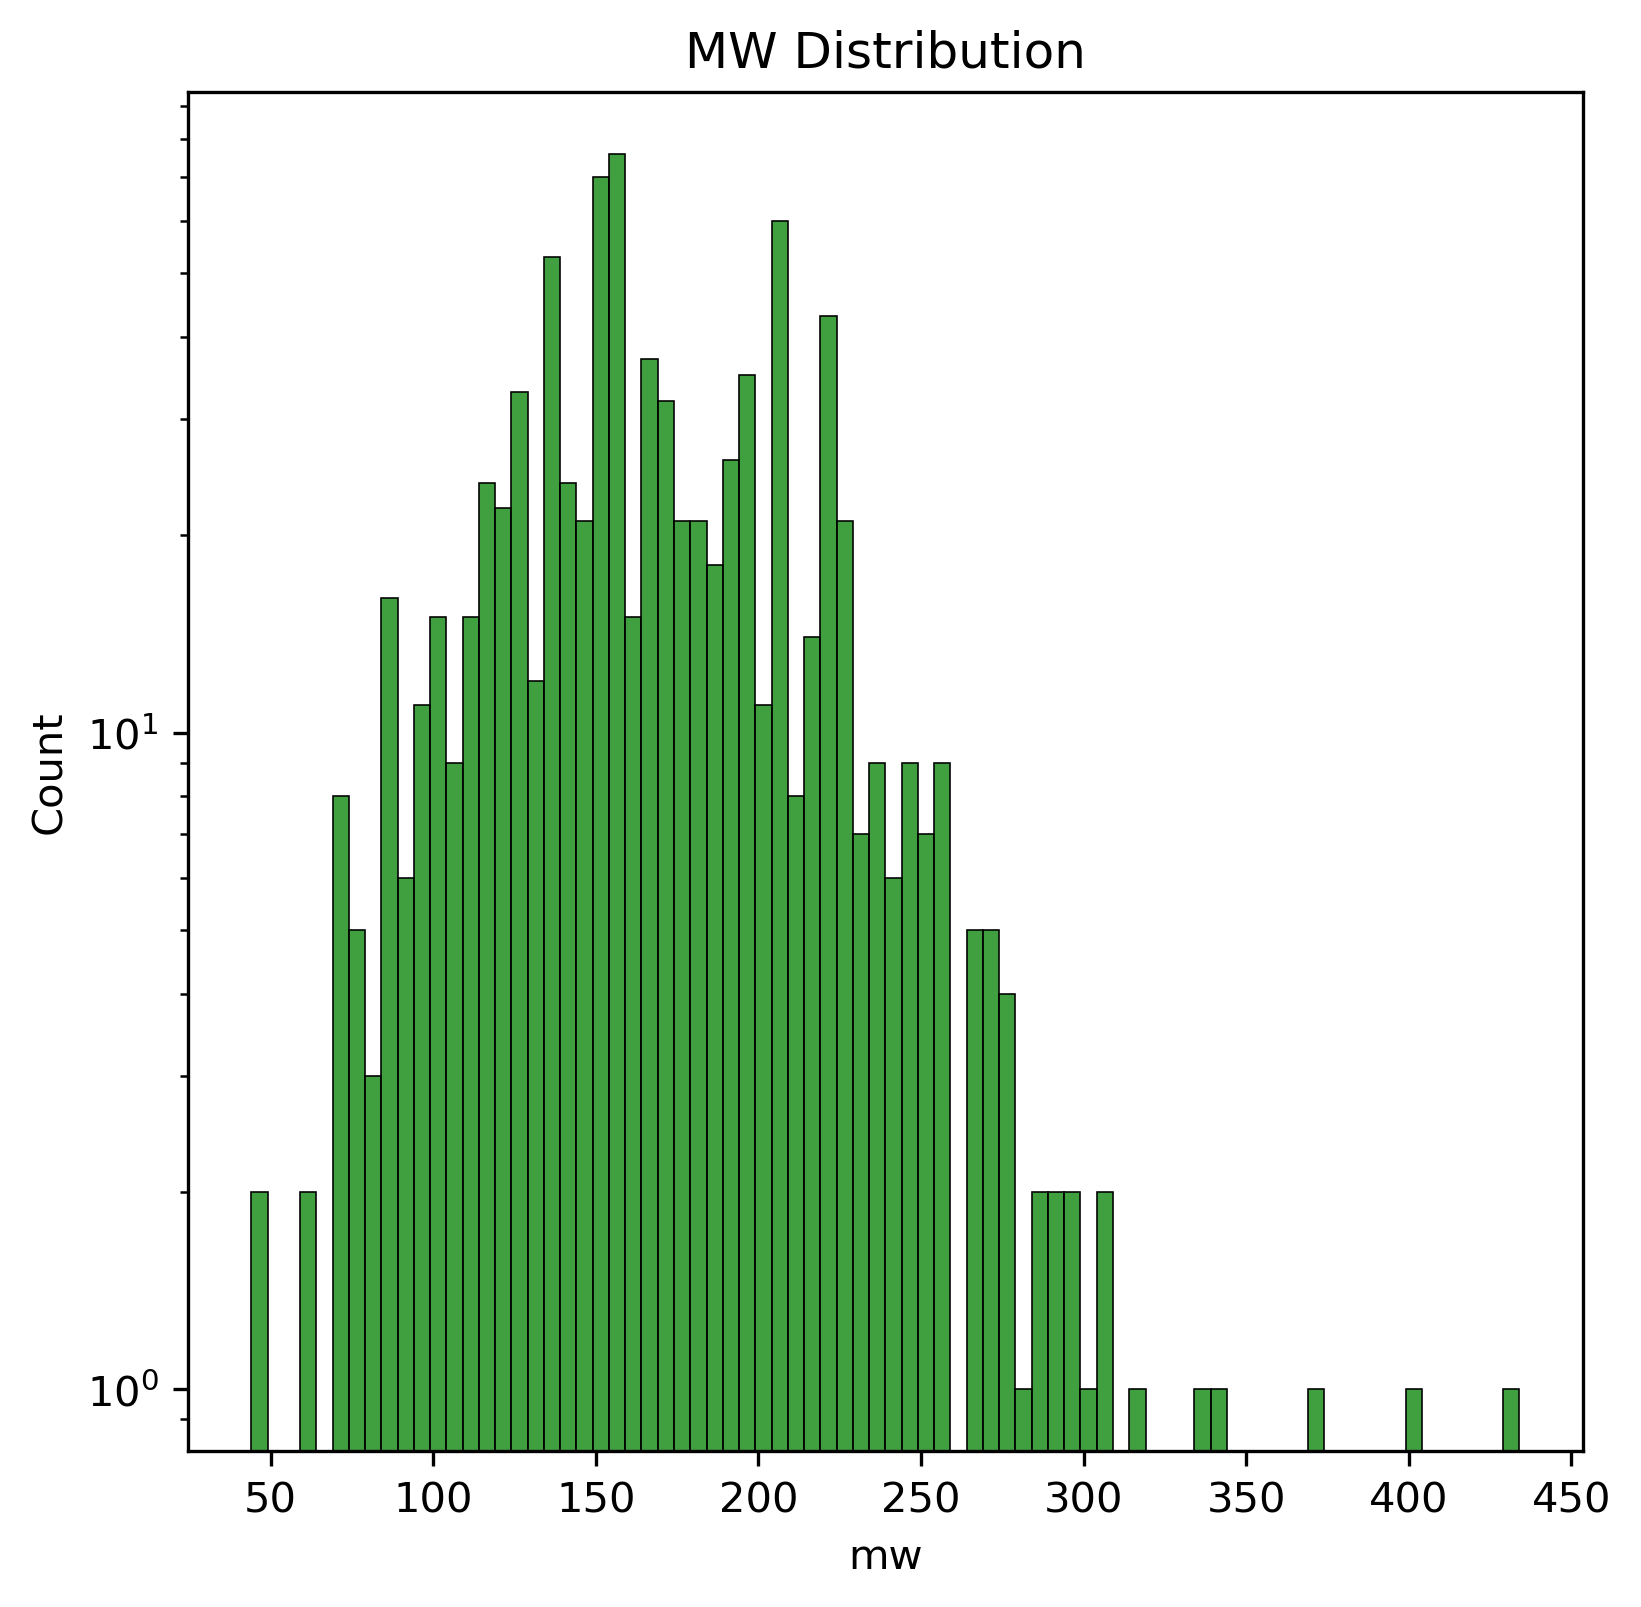

In [66]:
df_filtered['rdkit'] = df_filtered.apply(lambda row: Chem.MolFromSmiles(row['IsomericSMILES']), axis=1)
df_filtered['mw'] = df_filtered.apply(lambda row: ExactMolWt(row['rdkit']), axis=1)
 
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.histplot(df_filtered['mw'], ax=ax, binwidth=5, color='green')
ax.set_title("MW Distribution")
#ax.set_xlim([0,500])
g.set_yscale("log")
#ax.set_ylim([0, 100])

(0.5, 5000)

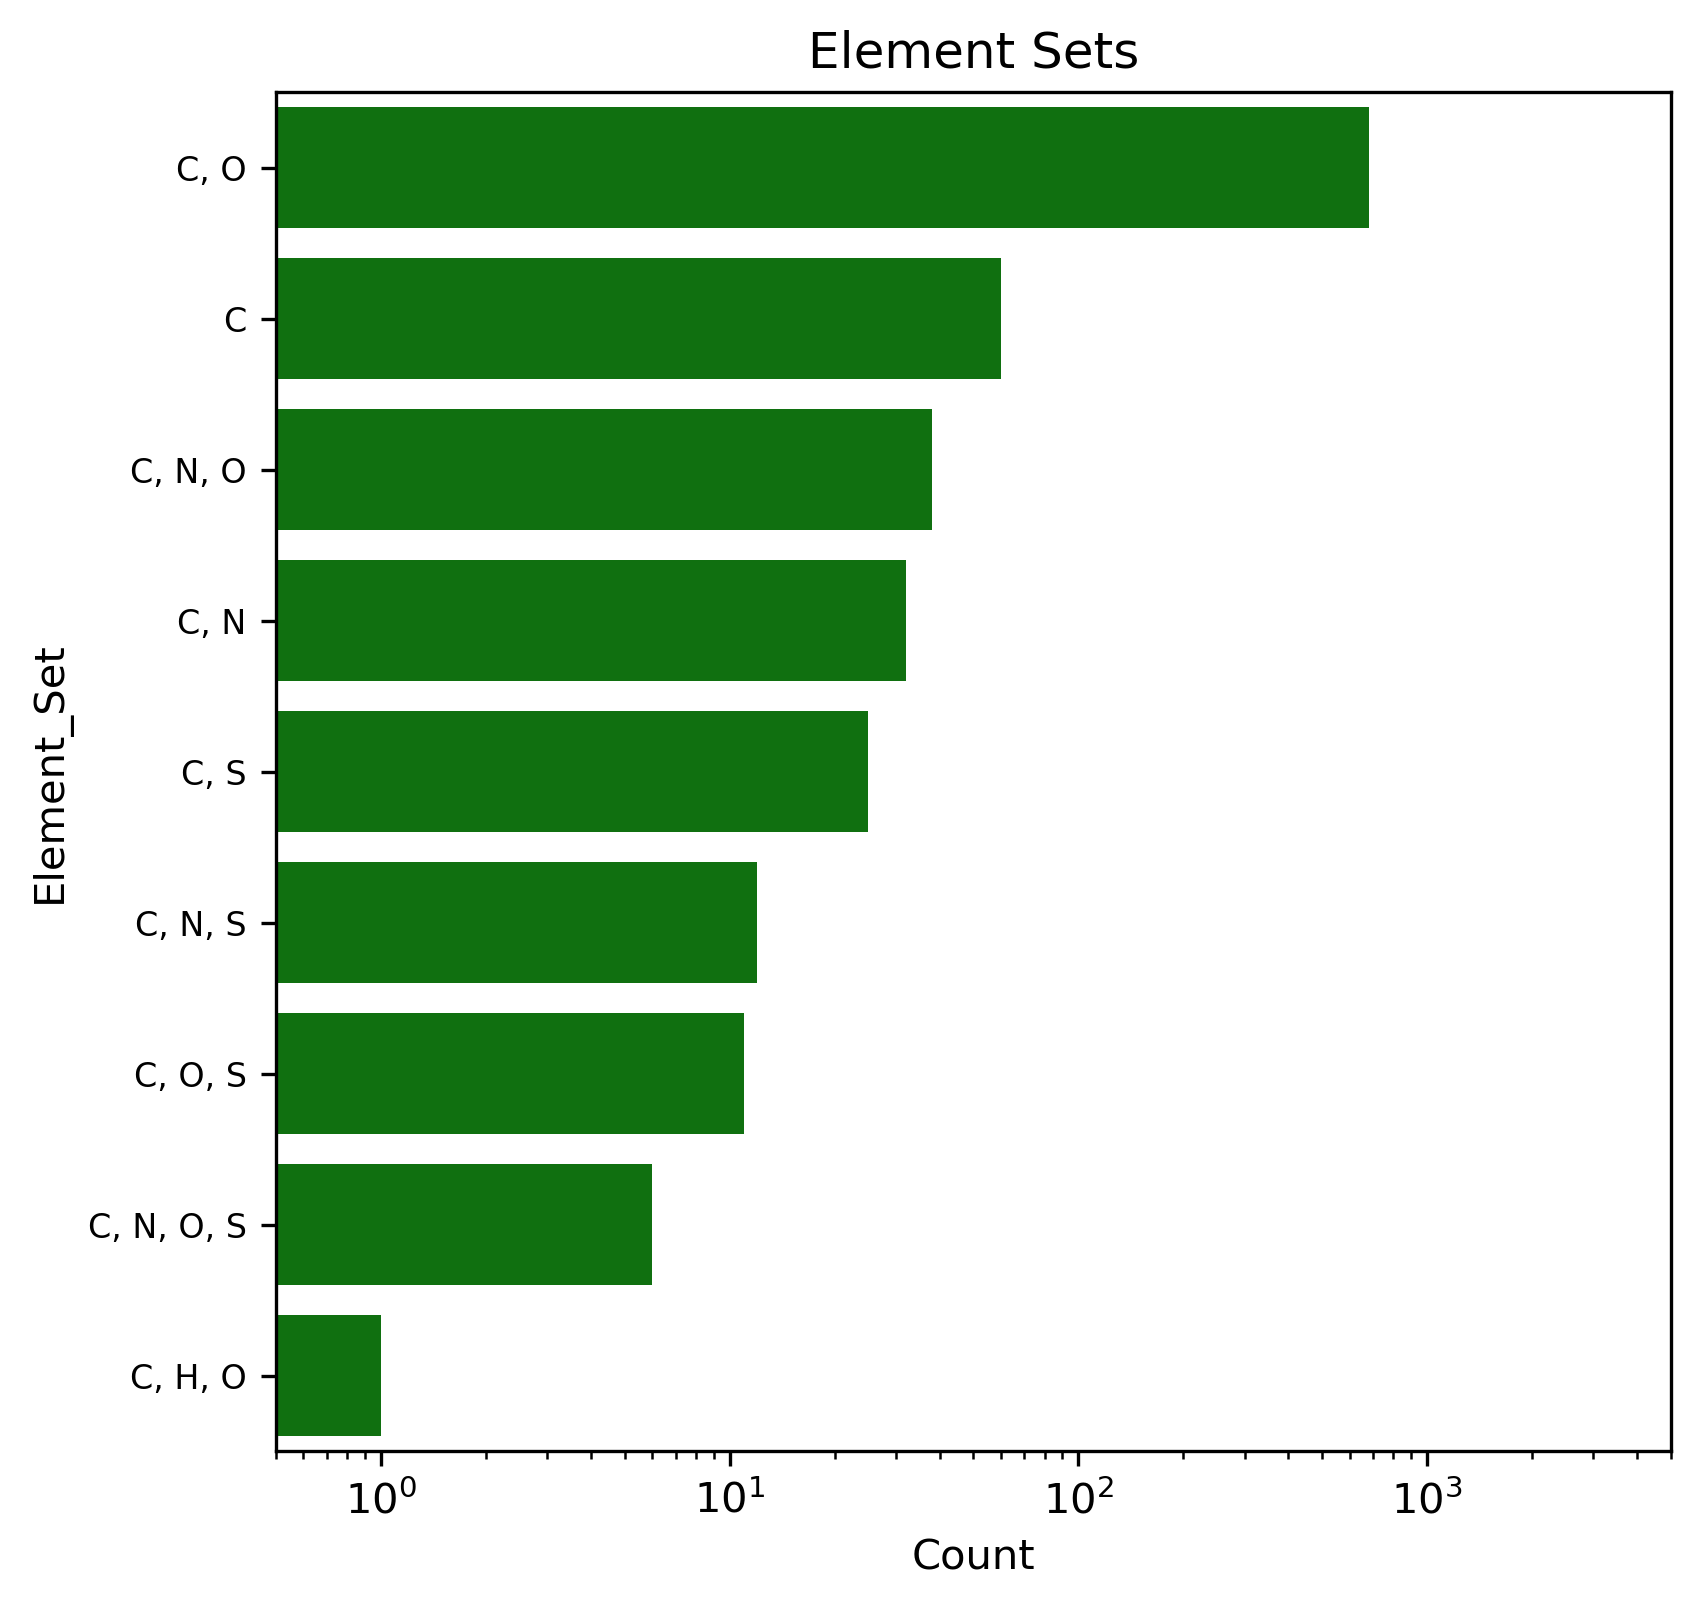

In [67]:
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
        return tuple(sorted(elements))
    else:
        return []
    
df_filtered['Element_Sets'] = df_filtered['IsomericSMILES'].apply(get_elements)

# Create a Counter to count the occurrences of each set of elements
element_set_counts = Counter(df_filtered['Element_Sets'])

element_set_counts_df = pd.DataFrame(
    list(element_set_counts.items()), 
    columns=['Element_Set', 'Count']
)

# Convert tuple to string for better plotting
element_set_counts_df['Element_Set'] = element_set_counts_df['Element_Set'].apply(lambda x: ', '.join(x))

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.barplot(data=element_set_counts_df.sort_values('Count', ascending=False), y='Element_Set', x='Count', color='green', ax=ax, orient="h")

g.set_xscale("log")

ax.set_title("Element Sets")

# Rotate the x-axis labels for better readability
#plt.yticks(rotation=90, ha='center', size=6)
plt.yticks(size=8)

ax.set_xlim([0.5,5000])
